In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
import pywt
def wavelet(data, level, wavelet):
    (cA, cD) = pywt.dwt(data, wavelet=wavelet)
    for i in range(1, level):
        (cA, cD) = pywt.dwt(cA, wavelet=wavelet)
    return cA, cD



In [7]:
gestures = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]
num_samples = 50
num_gestures = len(gestures)

one_hot = np.eye(len(gestures))



fulldata = pd.DataFrame(columns = ['aX','aY','aZ','gX','gY','gZ'])
fullwavedata = pd.DataFrame(columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'])
formatdata = pd.DataFrame()
formatwavedata = pd.DataFrame()

labels = []

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        filepath = 'hand/hand_{0}_{1}.csv'.format(gesture, i)
        data = pd.read_csv(filepath, index_col=False)
        wavedata = pd.DataFrame()
        
        level1 = 5
        wavetype1 = 'db20'
        
        wavedata['aX_A1'], wavedata['aX_D1'] = wavelet(data['aX'], level=level1, wavelet=wavetype1)
        wavedata['aY_A1'], wavedata['aY_D1'] = wavelet(data['aY'], level=level1, wavelet=wavetype1)
        wavedata['aZ_A1'], wavedata['aZ_D1'] = wavelet(data['aZ'], level=level1, wavelet=wavetype1)

        wavedata['gX_A1'], wavedata['gX_D1'] = wavelet(data['gX'], level=level1, wavelet=wavetype1)
        wavedata['gY_A1'], wavedata['gY_D1'] = wavelet(data['gY'], level=level1, wavelet=wavetype1)
        wavedata['gZ_A1'], wavedata['gZ_D1'] = wavelet(data['gZ'], level=level1, wavelet=wavetype1)
        
        level2 = 3
        wavetype2 = 'rbio2.2'

        wavedata['aX_A2'], wavedata['aX_D2'] = wavelet(data['aX'], level=level2, wavelet=wavetype2)
        wavedata['aY_A2'], wavedata['aY_D2'] = wavelet(data['aY'], level=level2, wavelet=wavetype2)
        wavedata['aZ_A2'], wavedata['aZ_D2'] = wavelet(data['aZ'], level=level2, wavelet=wavetype2)

        wavedata['gX_A2'], wavedata['gX_D2'] = wavelet(data['gX'], level=level2, wavelet=wavetype2)
        wavedata['gY_A2'], wavedata['gY_D2'] = wavelet(data['gY'], level=level2, wavelet=wavetype2)
        wavedata['gZ_A2'], wavedata['gZ_D2'] = wavelet(data['gZ'], level=level2, wavelet=wavetype2)
        
        wavelen = len(wavedata)
        
        fullwavedata = fullwavedata.append(wavedata)
        fulldata = fulldata.append(data)
        label = gesture
        labels.append(label)
        del data, wavedata

labels = np.array(labels)


In [ ]:
normaldata = (fulldata - fulldata.min()) / (fulldata.max()-fulldata.min())
normaldata.describe()

In [ ]:
formatdata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        
        index = idx*num_samples*250 + (i-1) * 250
        #print(index, index+250)
        dataf = normaldata.iloc[index:index+250].to_numpy().flatten().tolist()
        formatdata[idx*num_samples+i-1] = dataf
        del dataf
        
        
formatdata = formatdata.transpose().to_numpy()
formatdata


In [8]:
minval = np.array(fullwavedata.min(), dtype='float32')
maxval = np.array(fullwavedata.max(), dtype='float32')

In [9]:
parameters = pd.DataFrame([minval, maxval], columns = ['aX_A1','aX_D1','aY_A1','aY_D1','aZ_A1','aZ_D1','gX_A1','gX_D1','gY_A1','gY_D1','gZ_A1','gZ_D1',
                                       'aX_A2','aX_D2','aY_A2','aY_D2','aZ_A2','aZ_D2','gX_A2','gX_D2','gY_A2','gY_D2','gZ_A2','gZ_D2'], index=['min','max'])
parameters.to_csv('dataparameters.csv')

In [10]:
normalwavedata = (fullwavedata - fullwavedata.min()) / (fullwavedata.max()-fullwavedata.min())
normalwavedata.describe()

,aX_A1,aX_D1,aY_A1,aY_D1,aZ_A1,aZ_D1,gX_A1,gX_D1,gY_A1,gY_D1,...,aY_A2,aY_D2,aZ_A2,aZ_D2,gX_A2,gX_D2,gY_A2,gY_D2,gZ_A2,gZ_D2
count,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,...,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000,26400.000000
mean,0.267300,0.474299,0.532783,0.475571,0.587976,0.513237,0.493822,0.496712,0.483855,0.515383,...,0.432839,0.449727,0.558324,0.521365,0.500183,0.519830,0.410186,0.521206,0.502551,0.583230
std,0.123643,0.066293,0.116047,0.059190,0.129127,0.080489,0.125645,0.090167,0.116264,0.072924,...,0.083774,0.033548,0.097088,0.042426,0.102759,0.048254,0.099510,0.040963,0.090144,0.035227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.193030,0.451570,0.475979,0.461617,0.511344,0.488324,0.429299,0.476434,0.403973,0.493319,...,0.403568,0.446310,0.494259,0.515400,0.482615,0.515702,0.388433,0.517965,0.492884,0.579189
50%,0.238372,0.475990,0.541994,0.478134,0.593200,0.513502,0.502039,0.497601,0.497887,0.511452,...,0.435093,0.449777,0.557355,0.521536,0.506969,0.519877,0.404442,0.521259,0.502341,0.582993
75%,0.316260,0.497073,0.597311,0.492333,0.673205,0.538372,0.545229,0.518854,0.545459,0.537361,...,0.470832,0.453207,0.617096,0.527778,0.523956,0.524138,0.415941,0.525350,0.515112,0.586998
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
formatwavedata = pd.DataFrame()

for idx, gesture in enumerate(gestures):
    for i in range(1, num_samples+1):
        
        index = idx*num_samples*wavelen + (i-1) * wavelen
        #print(index, index+250)
        wavedataf = normalwavedata.iloc[index:index+wavelen].to_numpy().flatten().tolist()
        formatwavedata[idx*num_samples+i-1] = wavedataf
        del wavedataf
        
        
formatwavedata = formatwavedata.transpose().to_numpy()
formatwavedata 


array([[0.2454407 , 0.41080022, 0.32581968, ..., 0.5188936 , 0.4929458 ,
        0.58779549],
       [0.19500412, 0.51896688, 0.61033764, ..., 0.52143732, 0.49012884,
        0.58391459],
       [0.22643872, 0.4297922 , 0.33365506, ..., 0.52195295, 0.49385348,
        0.58364604],
       ...,
       [0.56100788, 0.25162484, 0.60983698, ..., 0.51909722, 0.50125362,
        0.58275752],
       [0.629451  , 0.41301135, 0.71584526, ..., 0.52259185, 0.51834611,
        0.58284503],
       [0.62376549, 0.2756082 , 0.4846425 , ..., 0.52138206, 0.5016146 ,
        0.58184442]])

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(formatwavedata, labels, test_size=0.15)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

In [43]:
from sklearn.model_selection import StratifiedShuffleSplit

testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15)
valsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15/0.85)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
for train_index, val_index in valsplit.split(X_train, y_train):
    X_train, X_val = X_train[train_index], X_train[val_index]
    y_train, y_val = y_train[train_index], y_train[val_index]
    
for i in range(0,10):
    print('{3}: Train {0}; Test {1}; Val {2}'.format(np.size(np.where(y_train == i)) / len(y_train), np.size(np.where(y_test == i)) / len(y_test), np.size(np.where(y_val == i)) / len(y_val), i))

0: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
1: Train 0.08854166666666667; Test 0.0963855421686747; Val 0.0963855421686747
2: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
3: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
4: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
5: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
6: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
7: Train 0.09114583333333333; Test 0.08433734939759036; Val 0.0963855421686747
8: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036
9: Train 0.09114583333333333; Test 0.0963855421686747; Val 0.08433734939759036


In [44]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [45]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,

)
model.fit(X_train, y_train, 
            epochs=600,
            batch_size=32,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val))



Epoch 1/600
12/12 [==============================] - 1s 71ms/step - loss: 2.4077 - sparse_categorical_accuracy: 0.1172 - val_loss: 2.3226 - val_sparse_categorical_accuracy: 0.3253
Epoch 2/600
12/12 [==============================] - 0s 41ms/step - loss: 2.3528 - sparse_categorical_accuracy: 0.1484 - val_loss: 2.2602 - val_sparse_categorical_accuracy: 0.4337
Epoch 3/600
12/12 [==============================] - 0s 42ms/step - loss: 2.2891 - sparse_categorical_accuracy: 0.2083 - val_loss: 2.1861 - val_sparse_categorical_accuracy: 0.5422
Epoch 4/600
12/12 [==============================] - 1s 44ms/step - loss: 2.2291 - sparse_categorical_accuracy: 0.2396 - val_loss: 2.1111 - val_sparse_categorical_accuracy: 0.6024
Epoch 5/600
12/12 [==============================] - 1s 45ms/step - loss: 2.1351 - sparse_categorical_accuracy: 0.3177 - val_loss: 2.0006 - val_sparse_categorical_accuracy: 0.5181
Epoch 6/600
12/12 [==============================] - 1s 43ms/step - loss: 2.0483 - sparse_categorica

12/12 [==============================] - 1s 42ms/step - loss: 0.2747 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.3266 - val_sparse_categorical_accuracy: 0.8916
Epoch 47/600
12/12 [==============================] - 1s 43ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.9245 - val_loss: 0.3127 - val_sparse_categorical_accuracy: 0.9277
Epoch 48/600
12/12 [==============================] - 0s 41ms/step - loss: 0.3243 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.2954 - val_sparse_categorical_accuracy: 0.9277
Epoch 49/600
12/12 [==============================] - 0s 40ms/step - loss: 0.2834 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.2470 - val_sparse_categorical_accuracy: 0.9398
Epoch 50/600
12/12 [==============================] - 0s 41ms/step - loss: 0.2935 - sparse_categorical_accuracy: 0.8958 - val_loss: 0.2743 - val_sparse_categorical_accuracy: 0.9157
Epoch 51/600
12/12 [==============================] - 1s 42ms/step - loss: 0.2723 - sparse_categorical_accur

12/12 [==============================] - 0s 42ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9398
Epoch 92/600
12/12 [==============================] - 0s 41ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.9557 - val_loss: 0.2328 - val_sparse_categorical_accuracy: 0.9398
Epoch 93/600
12/12 [==============================] - 0s 39ms/step - loss: 0.1293 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.2073 - val_sparse_categorical_accuracy: 0.9398
Epoch 94/600
12/12 [==============================] - 0s 38ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.1684 - val_sparse_categorical_accuracy: 0.9277
Epoch 95/600
12/12 [==============================] - 0s 39ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.1932 - val_sparse_categorical_accuracy: 0.9398
Epoch 96/600
12/12 [==============================] - 0s 39ms/step - loss: 0.1083 - sparse_categorical_accur

12/12 [==============================] - 0s 40ms/step - loss: 0.0716 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.2944 - val_sparse_categorical_accuracy: 0.9277
Epoch 137/600
12/12 [==============================] - 0s 41ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.2687 - val_sparse_categorical_accuracy: 0.9518
Epoch 138/600
12/12 [==============================] - 0s 40ms/step - loss: 0.0356 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.2672 - val_sparse_categorical_accuracy: 0.9398
Epoch 139/600
12/12 [==============================] - 0s 40ms/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.2163 - val_sparse_categorical_accuracy: 0.9639
Epoch 140/600
12/12 [==============================] - 0s 40ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.1934 - val_sparse_categorical_accuracy: 0.9518
Epoch 141/600
12/12 [==============================] - 0s 41ms/step - loss: 0.0622 - sparse_categorical_

3/3 [==============================] - 0s 7ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.9518


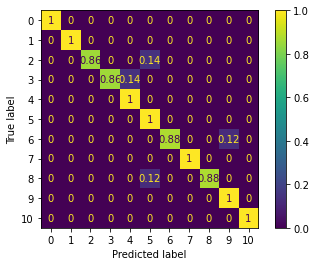

In [42]:
model.evaluate(X_test, y_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

prediction = model.predict(X_test)
prediction

prediction_lbl = np.argmax(prediction, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, prediction_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [46]:
#model = tf.keras.models.load_model('Training data/model1')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (Dense)                 (None, 1024)              1180672   
_________________________________________________________________
dropout_18 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_19 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
result (Dense)               (None, 11)               

In [88]:
tf.saved_model.save(
    model, 'testvar')


INFO:tensorflow:Assets written to: testvar\assets


INFO:tensorflow:Assets written to: testvar\assets


In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('test_model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\andre\AppData\Local\Temp\tmppn6r4u0b\assets


In [13]:
interpreter = tf.lite.Interpreter(model_path='test_model.tflite')

interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)

[{'name': 'data_input', 'index': 0, 'shape': array([   1, 1584]), 'shape_signature': array([  -1, 1584]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [32]:
trydata = np.resize(X_test[0], (1, 1584))

TypeError: _resize_dispatcher() got an unexpected keyword argument 'dtype'

In [34]:
input_data = np.float32(np.resize(X_test[46], (1, 1584)))
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(np.round(output_data, decimals=3))
print(y_test[46])

[[0.    0.004 0.    0.449 0.007 0.    0.    0.536 0.004 0.   ]]
7


In [26]:
for i in range(0, 113):
    input_data = np.float32(np.resize(X_test[i], (1, 1584)))
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_data

    if np.max(output_data) < 0.6:
        print('Unsure')
        print(i)

Unsure
46


In [16]:
np.argmax(output_data)
if max(output_data) < 0.5:
    print()

1

In [12]:
interpreter = tf.lite.Interpreter(model_path='test_model.tflite')

signatures = interpreter.get_signature_list()
print(signatures)
predictor = interpreter.get_signature_runner()
print(predictor)



{}


ValueError: SignatureDef method_name is None and model has 0 Signatures. None is only allowed when the model has 1 SignatureDef

In [127]:
output = predictor(data_input=np.float32(X_test[0]))['result']
output

array([[1.0964601e-07, 9.1763778e-04, 1.6810007e-05, 4.2849658e-03,
        2.6555134e-03, 2.2810149e-05, 2.0116172e-04, 9.7670448e-01,
        4.2905535e-06, 1.5192278e-02]], dtype=float32)

In [128]:
X_test[0].size

1584

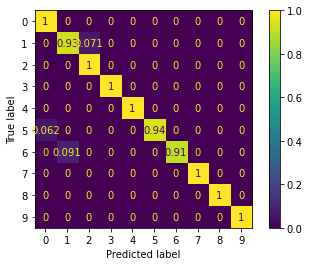

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

output_lbl = np.argmax(output, axis=1)
test_lbl = y_test

cm = confusion_matrix(test_lbl, output_lbl, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Train model on full data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow import keras
from tensorflow.keras import layers, callbacks

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = None
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1024, activation='relu', name='data')) # relu is used for performance
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(gestures), activation='softmax', name='result'))
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=25, # how many epochs to wait before stopping
    restore_best_weights=True,
    )



testsplit = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2)

for train_index, test_index in testsplit.split(formatwavedata, labels):
    X_train, X_test = formatwavedata[train_index], formatwavedata[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

history = model.fit(X_train, y_train, 
                    epochs=600,
                    batch_size=32,
                    callbacks=[early_stopping],
                    validation_data=(X_val, y_val),
                    verbose=1)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('number_model.tflite', 'wb') as f:
  f.write(tflite_model)


Epoch 1/600
14/14 [==============================] - 2s 72ms/step - loss: 2.4147 - sparse_categorical_accuracy: 0.1205 - val_loss: 2.3086 - val_sparse_categorical_accuracy: 0.3373
Epoch 2/600
14/14 [==============================] - 1s 52ms/step - loss: 2.3269 - sparse_categorical_accuracy: 0.1955 - val_loss: 2.2176 - val_sparse_categorical_accuracy: 0.2892
Epoch 3/600
14/14 [==============================] - 1s 43ms/step - loss: 2.2167 - sparse_categorical_accuracy: 0.2523 - val_loss: 2.1059 - val_sparse_categorical_accuracy: 0.4699
Epoch 4/600
14/14 [==============================] - 1s 42ms/step - loss: 2.1231 - sparse_categorical_accuracy: 0.3341 - val_loss: 1.9864 - val_sparse_categorical_accuracy: 0.5783
Epoch 5/600
14/14 [==============================] - 1s 41ms/step - loss: 1.9980 - sparse_categorical_accuracy: 0.3727 - val_loss: 1.8181 - val_sparse_categorical_accuracy: 0.6627
Epoch 6/600
14/14 [==============================] - 1s 54ms/step - loss: 1.8716 - sparse_categorica

14/14 [==============================] - 1s 38ms/step - loss: 0.2143 - sparse_categorical_accuracy: 0.9477 - val_loss: 0.1608 - val_sparse_categorical_accuracy: 0.9639
Epoch 47/600
14/14 [==============================] - 1s 42ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9386 - val_loss: 0.1656 - val_sparse_categorical_accuracy: 0.9759
Epoch 48/600
14/14 [==============================] - 1s 40ms/step - loss: 0.1963 - sparse_categorical_accuracy: 0.9545 - val_loss: 0.2018 - val_sparse_categorical_accuracy: 0.9398
Epoch 49/600
14/14 [==============================] - 1s 40ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.9636 - val_loss: 0.1102 - val_sparse_categorical_accuracy: 0.9880
Epoch 50/600
14/14 [==============================] - 1s 38ms/step - loss: 0.1594 - sparse_categorical_accuracy: 0.9614 - val_loss: 0.1102 - val_sparse_categorical_accuracy: 0.9759
Epoch 51/600
14/14 [==============================] - 1s 44ms/step - loss: 0.1560 - sparse_categorical_accur

14/14 [==============================] - 1s 42ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.0587 - val_sparse_categorical_accuracy: 0.9880
Epoch 92/600
14/14 [==============================] - 1s 45ms/step - loss: 0.0545 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0474 - val_sparse_categorical_accuracy: 0.9759
Epoch 93/600
14/14 [==============================] - 1s 43ms/step - loss: 0.0466 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.0321 - val_sparse_categorical_accuracy: 0.9880
Epoch 94/600
14/14 [==============================] - 1s 44ms/step - loss: 0.0391 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0397 - val_sparse_categorical_accuracy: 0.9880
Epoch 95/600
14/14 [==============================] - 1s 39ms/step - loss: 0.0408 - sparse_categorical_accuracy: 0.9932 - val_loss: 0.0408 - val_sparse_categorical_accuracy: 0.9880
Epoch 96/600
14/14 [==============================] - 1s 40ms/step - loss: 0.0472 - sparse_categorical_accur

 5/14 [=========>....................] - ETA: 0s - loss: 0.0353 - sparse_categorical_accuracy: 0.9937

## Hyperparameter Optimization

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, callbacks

hyperparameters = pd.DataFrame()
for s in range(6,12):
    for n in range(4, 10):
        validation = []
        for i in range(1,11):       
            
            model = None
            opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(2**s, activation='relu')) # relu is used for performance
            model.add(tf.keras.layers.Dense(2**s, activation='relu'))
            model.add(tf.keras.layers.Dense(2**s, activation='relu'))
            model.add(tf.keras.layers.Dense(len(gestures), activation='softmax'))
            model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy()])

            early_stopping = callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001, # minimium amount of change to count as an improvement
                patience=25, # how many epochs to wait before stopping
                restore_best_weights=True,
            )

            X_train, X_test, y_train, y_test = train_test_split(formatdata, labels, test_size=0.15)
            X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85)

            model.fit(X_train, y_train, 
                                epochs=600,
                                batch_size=2**n,
                                callbacks=[early_stopping],
                                validation_data=(X_val, y_val),
                                verbose=0)
            
            validation.append(model.evaluate(X_test, y_test, verbose=0))
            
        indexing = 'size={0},bs={1}'.format(2**s,2**n)
        hyperparameters[indexing] = np.average(validation, axis=0)
        print(indexing)
        hyperparameters.transpose().to_csv('Training data/Search results.csv') 

  
hyperparameters

In [ ]:
hyperparameters